# Exercise 1: GD on a 1D Function


Eta        | Final Theta     | Final Loss      | Behavior
------------------------------------------------------------
0.05       | 2.6353          | -0.8670         | Slow convergence (Under-stepping)
0.2        | 2.9999          | -1.0000         | Fast convergence (perfect stepping)
1.0        | 0.0000          | 8.0000          | Oscillation (Bouncing between 0 and 6)
------------------------------------------------------------


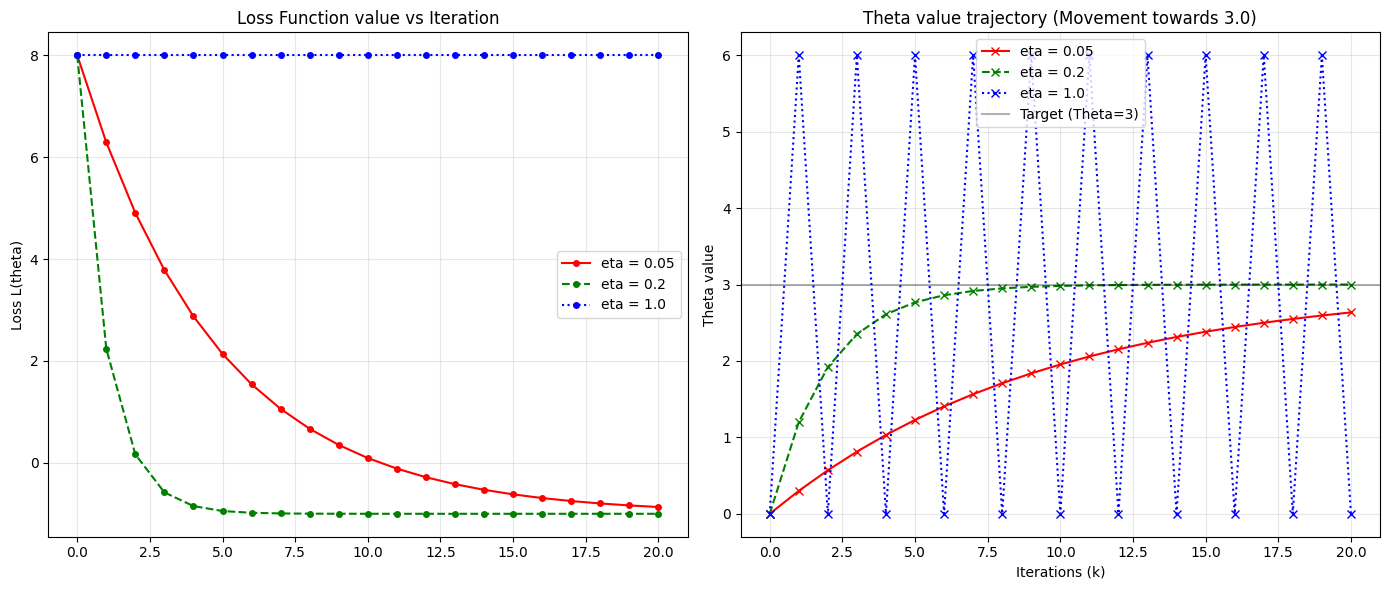

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # ==========================================
# 1. Define the function and gradient of it
# # ==========================================


def L(theta):
    """The loss function l(theta) = (theta -3)^2 + 1"""
    return ((theta - 3) ** 2) - 1


def grad_L(theta):
    """
    The gradient of the loss function.
    Derivate of (theta -3)**2 - 1 is 2(theta-3)
    """
    return 2 * (theta - 3)


# # ==========================================
# 2. Implement Gradient Descent
# # ==========================================


def run_gradient_descent(start_theta, learning_rate, maxitr):
    """
    Performs Gradient Descent till maxitr

    Returns:
    - theta_history: list of theta values at each step
    - loss_history: list of function values at each step
    """

    # Initial parameters
    theta = start_theta

    # Lists to store history
    # Later than used for plotting
    theta_history = [theta]
    loss_history = [L(theta)]

    for i in range(maxitr):
        # 1. Compute Gradient
        gradient = grad_L(theta)

        # 2. Update Theta (The Core Formula: theta_new = theta_old - eta * grad)
        theta = theta - learning_rate * gradient

        # save snapshot
        theta_history.append(theta)
        loss_history.append(L(theta))

    return theta_history, loss_history


# ==========================================
# 3. With different learning rates
# ==========================================
start_theta = 0.0
maxitr = 20
learning_rates = [0.05, 0.2, 1.0]

# Prepare the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
colors = ["red", "green", "blue"]
styles = ["-", "--", ":"]

print(f"{'Eta':<10} | {'Final Theta':<15} | {'Final Loss':<15} | {'Behavior'}")
print("-" * 60)  # divider

for i, eta in enumerate(learning_rates):
    # Run the algorithm
    thetas, losses = run_gradient_descent(start_theta, eta, maxitr)

    # Plot1: Loss vs Iterations tells the convergence
    ax1.plot(losses, label=f"eta = {eta}", color=colors[i], linestyle=styles[i], marker="o", markersize=4)

    # Plot2: theta trajectory on the line
    # Plotting the iterations vs thera to show the movement over the time on the real line
    ax2.plot(thetas, label=f"eta = {eta}", color=colors[i], linestyle=styles[i], marker="x")

    final_theta = thetas[-1]
    final_loss = losses[-1]

    behaviour = ""
    if eta == 0.05:
        behaviour = "Slow convergence (Under-stepping)"
    elif eta == 0.2:
        behaviour = "Fast convergence (perfect stepping)"
    elif eta == 1.0:
        behaviour = "Oscillation (Bouncing between 0 and 6)"

    print(f"{eta:<10} | {final_theta:<15.4f} | {final_loss:<15.4f} | {behaviour}")

print("-" * 60)

# ==========================================
# 4. Final plotting
# ==========================================

# Loss plot configurations
ax1.set_title("Loss Function value vs Iteration")
ax2.set_xlabel("Iteration (k)")
ax1.set_ylabel("Loss L(theta)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Trajectory plot settings
ax2.set_title("Theta value trajectory (Movement towards 3.0)")
ax2.set_xlabel("Iterations (k)")
ax2.set_ylabel("Theta value")
ax2.axhline(y=3.0, color="black", linestyle="-", alpha=0.3, label="Target (Theta=3)")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## OBSERVATIONS & COMMENTS

### 1. Eta = 0.05 (Small Step)

- **Behavior:** The loss decreases monotonically but very slowly.
- **Theoretical Link:**  
  When the step-size is too small, we take tiny steps down the hill.  
  We are safe, but it takes many iterations to reach the minimum.

### 2. Eta = 0.2 (Medium Step)

- **Behavior:** The loss decreases rapidly and settles at the minimum _(θ = 3)_.
- **Theoretical Link:**  
  This is the _“Just Right”_ zone. The step size matches the  
  scale of the gradient, allowing efficient descent without overshooting.

### 3. Eta = 1.0 (Large Step)

- **Behavior:** The theta value bounces perfectly between **0.0** and **6.0**.  
  The loss never goes to **1.0** (the minimum); it stays stuck at **10.0**.
- **Theoretical Link:**  
  This demonstrates **oscillation** caused by a step size  
  at the limit of stability. The step is so large it jumps strictly to the  
  other side of the valley at the exact same height, never descending.

---

### Note on Convexity

Since the function

(theta - 3)^2 + 1

is **strictly convex** (a perfect bowl), there are no local minima to get stuck in.  
The only risks are **slow convergence** or **divergence** due to step size.


# Exercise 2: Backtracking Line Search


Start Theta  | Final Theta  | Converged To 
------------------------------------------------------------
Running for labels0...
   -> Converged at iter 19: grad_norm=0.000006, step_norm=0.000001
-2.0         | 1.2247       | Right Min (+1.22)
------------------------------------------------------------
Running for labels1...
   -> Converged at iter 18: grad_norm=0.000006, step_norm=0.000001
0.5          | 1.2247       | Right Min (+1.22)
------------------------------------------------------------
Running for labels2...
   -> Converged at iter 19: grad_norm=0.000006, step_norm=0.000001
2.0          | -1.2247      | Left Min (-1.22)
------------------------------------------------------------


<function matplotlib.pyplot.show(close=None, block=None)>

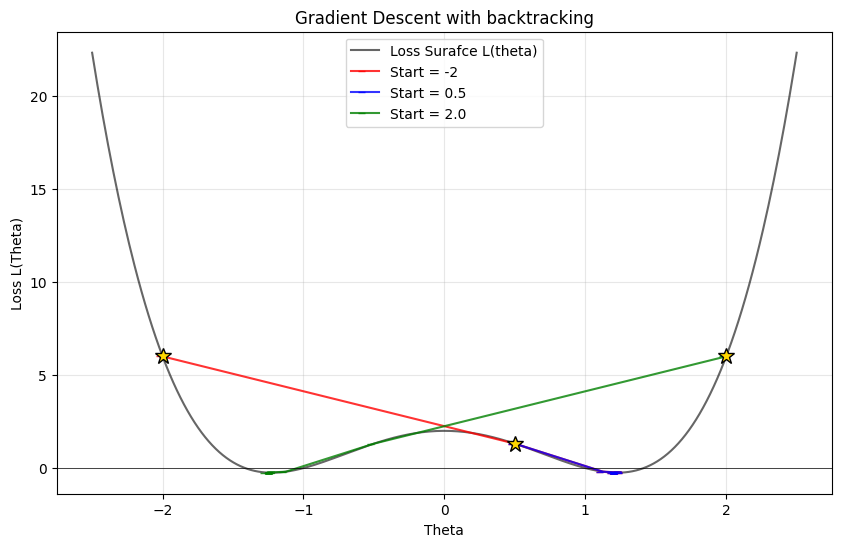

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Define the function and its Gradient
# ==========================================


def L(theta):
    """
    Non-convex function: L(theta) = theta^4 - 3*theta^2 + 2
    this is a 'double-well'potential. The curve looks like a “W”
    """
    return theta**4 - 3 * (theta**2) + 2


def grad_L(theta):
    """
    Gradient: 4*theta^3 - 6*theta
    """
    return 4 * (theta**3) - (6 * theta)


# ==========================================
# 2. Backtracking Line Search (Armijo)
# ==========================================


def backtracking(L, grad_L, theta, eta0=1.0, beta=0.5, c=1e-4):
    """
    Return a step size 'eta' that satisfies the Armijo condition:
    L(theta - eta*grad) <= L(theta) - c * eta * ||g||^2

    Inputs:
    - L:      R^n -> R
    - grad_L: R^n -> R^d
    - theta:  current point (np.ndarray)
    - eta0:   initial step size (start large)
    - beta:   shrinking factor in (0,1) (e.g. 0.5 cuts it in half)
    - c:      Armijo constant in (0,1) (strictness to decrease)
    """

    eta = eta0
    g = grad_L(theta)
    g_norm2 = np.dot(g, g)  # also For 1D, dot product is just square => g**2

    # Keep on shrinkning until the new loss is NOT good enough
    while L(theta - eta * g) > L(theta) - c * eta * g_norm2:
        eta *= beta

    return eta


# ==========================================
# 3. Gradient Descent with Backtracking
# ==========================================
def GD_with_backtracking(theta_0, maxitr=1000, tolL=1e-6, toltheta=1e-6):
    """
    Implement GD with the stopping criteria
    1. Gradient is close to - (Mathematical Minimum)
    2. Step size is very small(Practiacl Scaling)
    """
    theta = theta_0
    history = [theta]

    for i in range(maxitr):
        # 1. calculate dynamic steo size for this specific spot
        eta = backtracking(L, grad_L, theta, eta0=1.0, beta=0.5)

        # 2. update the values
        grad = grad_L(theta)
        theta_new = theta - eta * grad

        # 3. checking stopping criterias
        grad_norm = np.abs(grad)  # Norm of gradient
        step_norm = np.abs(theta_new - theta)  # Norm of the step (change in theta)

        # record new theta anyway
        history.append(theta_new)

        # Check stopping criteria
        if (grad_norm < tolL) or (step_norm < toltheta):
            print(f"   -> Converged at iter {i}: grad_norm={grad_norm:.6f}, step_norm={step_norm:.6f}")
            break

        # update
        theta = theta_new

    return np.array(history)


# ==========================================
# 4. Run the experiment & visualization
# ==========================================
start_points = [-2.0, 0.5, 2.0]
colors = ["red", "blue", "green"]
labels = ["Start = -2", "Start = 0.5", "Start = 2.0"]

# prepare the background curves
x_grid = np.linspace(-2.5, 2.5, 400)
y_grid = L(x_grid)

plt.figure(figsize=(10, 6))
plt.plot(x_grid, y_grid, "k-", linewidth=1.5, alpha=0.6, label="Loss Surafce L(theta)")

print(f"{'Start Theta':<12} | {'Final Theta':<12} | {'Converged To'} ")
print("-" * 60)

for i, theta0 in enumerate(start_points):
    print(f"Running for labels{i}...")

    # Run optimization
    path = GD_with_backtracking(theta0)

    # plot trajectory
    path_y = L(path)
    plt.plot(path, path_y, marker=0, markersize=5, linestyle="-", color=colors[i], label=labels[i], alpha=0.8)

    # mark the start
    plt.plot(path[0], path_y[0], marker="*", markersize=12, color="gold", markeredgecolor="black")

    # print stats
    converged_to = "Left Min (-1.22)" if path[-1] < 0 else "Right Min (+1.22)"
    print(f"{theta0:<12} | {path[-1]:<12.4f} | {converged_to}")
    print("-" * 60)


plt.title("Gradient Descent with backtracking")
plt.xlabel("Theta")
plt.ylabel("Loss L(Theta)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color="black", linewidth=0.5)
plt.show

---

## 5. Discussion & Reflection

**DISCUSSION**

### 1. Stopping Criteria (Class Implementation)

We now use two checks to stop the loop early:

* **`grad_norm < tolL`** — Confirms we are mathematically at a flat spot (stationary point).
* **`step_norm < toltheta`** — Confirms we have stopped moving.
  This is crucial when the learning rate (`eta`) becomes very small due to backtracking, which can stall the algorithm even if the gradient is not exactly zero.

---

### 2. Why do different initializations converge to different minima?

- The function is **non-convex (double-well)**.
- **Start = −2** → Falls into the **left valley**.
- **Start = 2** → Falls into the **right valley**.
- **Start = 0.5** → On the right slope of the central hill → Falls **right**.

---

### 3. Failure of Constant Step Size

- Backtracking prevents divergence on the steep walls (at (x = 2) or (x = -2)) by **drastically shrinking `eta`**,
  while allowing **larger steps near the bottom**.


# Exercise 3: GD in 2D


Running GD with eta=0.02...
Running GD with eta=0.05...
Running GD with eta=0.1...
   -> Diverged at iteration 5!


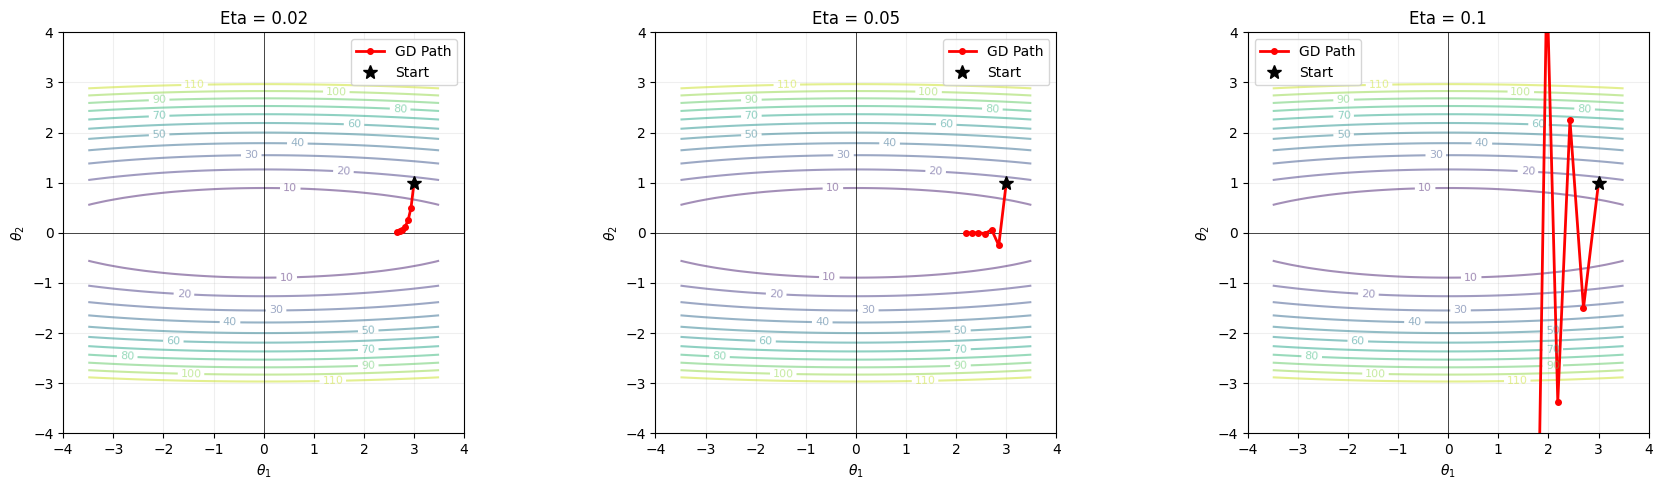

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Define the Problem (Ill-Conditioned Matrix)
# ==========================================
# A = [[1, 0], [0, 25]]
# Eigenvalues are 1 and 25. Condition number = 25.
A = np.diag([1.0, 25.0])


def grad_L(theta):
    """
    Gradient of L(theta) = 1/2 * theta.T * A * theta
    Nabla L = A * theta
    """
    return A @ theta


# ==========================================
# Gradient Descent implementation (2D)
# ==========================================


def gd_2d_fixed_step(start_theta, eta, n_iterations):
    """
    Performs GD with a FIXED step size (eta).
    We use this instead of Backtracking because Exercise 3 specifically
    asks to demonstrate what happens when eta is chosen poorly.
    """
    theta = np.array(start_theta, dtype=float)
    history = [theta.copy()]

    for k in range(n_iterations):
        g = grad_L(theta)

        # Standard Update Rule (Fixed Eta)
        theta = theta - eta * g

        # Safety break if values explode (divergence)
        if np.linalg.norm(theta) > 10:
            print(f"   -> Diverged at iteration {k}!")
            break

        history.append(theta.copy())
    return np.array(history)


# ==========================================
# 3. Visualization Helper ==========================================
def quad_levelsets(ax, A, xlim=(-3.5, 3.5), ylim=(-3, 3), ngrid=100, ncontours=12):
    """
    Plots the level sets using the exact formula from class:
    0.5*(A[0,0]*X**2 + 2*A[0,1]*X*Y + A[1,1]*Y**2)

    Modified slightly to take 'ax' for subplotting.
    """
    xs = np.linspace(xlim[0], xlim[1], ngrid)
    ys = np.linspace(ylim[0], ylim[1], ngrid)
    X, Y = np.meshgrid(xs, ys)

    # This handles non-diagonal A correctly (includes X*Y term)
    Z = 0.5 * (A[0, 0] * X**2 + 2 * A[0, 1] * X * Y + A[1, 1] * Y**2)

    cs = ax.contour(X, Y, Z, levels=ncontours, cmap="viridis", alpha=0.5)
    ax.clabel(cs, inline=True, fontsize=8)

    ax.axhline(0, lw=0.5, color="k")
    ax.axvline(0, lw=0.5, color="k")

    # Equivalent to plt.gca().set_aspect('equal', 'box')
    ax.set_aspect("equal", "box")

    ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$")
    # important for divergent cases to lock the axes
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

    ax.grid(alpha=0.2)


# ==========================================
# 4. Run Experiments
# ==========================================
etas = [0.02, 0.05, 0.1]
start_theta = [3.0, 1.0]  # Start far away to see the path
#  to clearly spot the divergence
iterations = 20 if eta < 0.08 else 6

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, eta in enumerate(etas):
    ax = axes[i]

    # 1. Draw the map (using class-style levelsets)
    quad_levelsets(ax, A)

    # 2. Run GD (Fixed Step)
    print(f"Running GD with eta={eta}...")
    path = gd_2d_fixed_step(start_theta, eta, iterations)

    # 3. Overlay the iterates theta^(k)
    ax.plot(path[:, 0], path[:, 1], "o-", linewidth=2, color="red", markersize=4, label="GD Path")
    ax.plot(start_theta[0], start_theta[1], "k*", markersize=10, label="Start")

    ax.set_title(f"Eta = {eta}")
    ax.legend()


plt.tight_layout()
plt.show()

## 5. Comments & Analysis

**Analysis of Ill-Conditioning**

### 1. Elongated Ellipses

- Using the class formula, we see the level sets are **narrow ellipses**.
- $A_{1,1} = 25$ means the valley is **25× steeper in the Y-direction than in the X-direction**.

### 2. Zig-Zag Behavior ($\eta = 0.05$)

- The gradient points **perpendicular to the contour lines**.
- Because the valley is narrow, the gradient points strongly _across_ the valley (vertical) rather than _along_ the valley (horizontal toward the minimum).
- At $\eta = 0.05$, we jump all the way to the opposite wall. This produces the **zig-zag behavior**.

### 3. Divergence ($\eta = 0.1$)

- The optimization path **explodes outward**.
- Stability requires $\eta < \frac{2}{\lambda_{\max}}$.
- Here, $\lambda_{\max} = 25$, so the limit is $\frac{2}{25} = 0.08$.
- Since $0.1 > 0.08$, the algorithm is **mathematically guaranteed to diverge**.

> **Note:** If we used the class's `GD_backtracking` method, it would detect instability at $\eta = 0.1$ and automatically shrink it, preventing the visible divergence and hiding this phenomenon.


# Exercise 4: Exact Line Search vs Backtracking
